In [ ]:
import pandas as pd

df = pd.read_csv('chatgpt.csv')

In [ ]:
df.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


<function matplotlib.pyplot.show(close=None, block=None)>

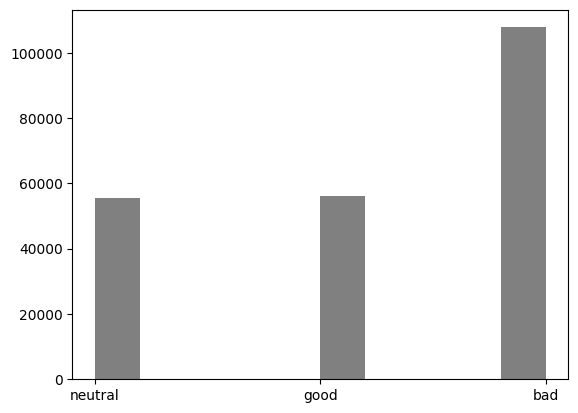

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df['labels'], color = 'gray')
plt.show

In [ ]:
df.shape

(219294, 3)

PREPROCESSING

In [ ]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

my_stemmer = PorterStemmer()
nltk.download('wordnet')
nltk.download('stopwords')
num_reviews = df['tweets'].size
nltk.download('punkt')

def preprocessor(raw_review):
    clean1 = re.sub(r'http\S+', ' ', raw_review)
    clean2 = re.sub(r'www\S+', ' ', clean1)
    clean3 = re.sub(r'@\w+', ' ', clean2)
    clean4 = re.sub(r'#\w+', ' ', clean3)
    letters_only = re.sub("[^a-zA-Z]", " ", clean4)
    words = word_tokenize(letters_only.lower())
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in meaningful_words]
    # return " ".join(lemmatized_words)
    return lemmatized_words


df['tokenized'] = df['tweets'].apply(preprocessor)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df.head()

,Unnamed: 0,tweets,labels,tokenized
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral,"[chatgpt, optimizing, language, model, dialogue]"
1,1,"Try talking with ChatGPT, our new AI system wh...",good,"[try, talking, chatgpt, new, ai, system, optim..."
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral,"[chatgpt, optimizing, language, model, dialogu..."
3,3,"THRILLED to share that ChatGPT, our new model ...",good,"[thrilled, share, chatgpt, new, model, optimiz..."
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad,"[minute, ago, released, new, chatgpt, n, nand,..."


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')
def preprocess_data(df):
    word_counts = defaultdict(int)
    label_counts = defaultdict(int)

    for i, row in df.iterrows():
        label, text = row['labels'], row['tokenized']

        # Add POS tagging
        pos_tags = pos_tag(text)

        label_counts[label] += 1
        for word, pos_tag in pos_tags:
            word_counts[(word, pos_tag)] += 1  # Store word and its POS tag

    return word_counts, label_counts
def train_hmm(word_counts, label_counts):
    initial_probs = {}
    transition_probs = defaultdict(lambda: defaultdict(int))
    emission_probs = defaultdict(lambda: defaultdict(int))

    total_labels = sum(label_counts.values())

    for label, count in label_counts.items():
        initial_probs[label] = count / total_labels

    for word_pos, count in word_counts.items():
        word, pos_tag = word_pos

        for label in label_counts.keys():
            transition_probs[label][word_pos] = count / label_counts[label]

        total_emissions = sum(transition_probs[label].values())
        for word_pos in transition_probs[label].keys():
            emission_probs[label][word_pos] = transition_probs[label][word_pos] / total_emissions

    return initial_probs, transition_probs, emission_probs

def viterbi(tweet, initial_probs, transition_probs, emission_probs):
    if len(tweet) == 0:
        return []

    T = len(tweet)
    N = len(sentiment_labels)

    trellis = np.zeros((N, T))
    backpointers = np.zeros((N, T), dtype=int)

    for s in range(N):
        trellis[s, 0] = initial_probs[sentiment_labels[s]] * emission_probs[sentiment_labels[s]][(tweet[0], pos_tag[0])]

    for t in range(1, T):
        for s in range(N):
            max_prob = 0
            max_state = 0
            for prev_s in range(N):
                prob = trellis[prev_s, t-1] * transition_probs[sentiment_labels[prev_s]][(tweet[t], pos_tag[t])] * emission_probs[sentiment_labels[s]][(tweet[t], pos_tag[t])]
                if prob > max_prob:
                    max_prob = prob
                    max_state = prev_s
            trellis[s, t] = max_prob
            backpointers[s, t] = max_state

    path = np.zeros(T, dtype=int)
    path[T-1] = np.argmax(trellis[:, T-1])
    for t in range(T-2, -1, -1):
        path[t] = backpointers[path[t+1], t+1]

    predicted_labels = [sentiment_labels[state] for state in path]
    return predicted_labels


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
train_df = df.sample(frac=0.8, random_state=1)
test_df = df.drop(train_df.index)


In [ ]:
df = df[:100000]

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag as pt
import numpy as np
from collections import defaultdict

sentiment_labels = ['good', 'bad', 'neutral']

initial_probs = {}
transition_probs = defaultdict(lambda: defaultdict(int))
emission_probs = defaultdict(lambda: defaultdict(int))

def preprocess_data(df):
    word_counts = defaultdict(int)
    label_counts = defaultdict(int)

    for i, row in df.iterrows():
        label, text = row['labels'], row['tokenized']

        pos_tags = pt(text)

        label_counts[label] += 1
        for word, pos_tag in pos_tags:
            word_counts[(word, pos_tag)] += 1

    return word_counts, label_counts


def train_hmm(word_counts, label_counts):
    global initial_probs
    global transition_probs
    global emission_probs

    total_labels = sum(label_counts.values())

    for label, count in label_counts.items():
        initial_probs[label] = count / total_labels

    for word_pos, count in word_counts.items():
        word, pos_tag = word_pos

        for label in label_counts.keys():
            transition_probs[label][word_pos] = count / label_counts[label]

        total_emissions = sum(transition_probs[label].values())
        for word_pos in transition_probs[label].keys():
            emission_probs[label][word_pos] = transition_probs[label][word_pos] / total_emissions


def viterbi(tweet, initial_probs, transition_probs, emission_probs):
    if len(tweet) == 0:
        return []

    T = len(tweet)
    N = len(sentiment_labels)

    trellis = np.zeros((N, T))
    backpointers = np.zeros((N, T), dtype=int)

    for s in range(N):
        trellis[s, 0] = initial_probs[sentiment_labels[s]] * emission_probs[sentiment_labels[s]][(tweet[0], pos_tag[0])]

    for t in range(1, T):
        for s in range(N):
            max_prob = 0
            max_state = 0
            for prev_s in range(N):
                prob = trellis[prev_s, t-1] * transition_probs[sentiment_labels[prev_s]][(tweet[t], pos_tag[t])] * \
                       emission_probs[sentiment_labels[s]][(tweet[t], pos_tag[t])]
                if prob > max_prob:
                    max_prob = prob
                    max_state = prev_s
            trellis[s, t] = max_prob
            backpointers[s, t] = max_state

    path = np.zeros(T, dtype=int)
    path[T-1] = np.argmax(trellis[:, T-1])
    for t in range(T-2, -1, -1):
        path[t] = backpointers[path[t+1], t+1]

    predicted_labels = [sentiment_labels[state] for state in path]
    return predicted_labels


train_df = df.sample(frac=0.8, random_state=1)
test_df = df.drop(train_df.index)
word_counts, label_counts = preprocess_data(train_df)

train_hmm(word_counts, label_counts)


In [ ]:

num_correct = 0
num_total = 0

for i, row in test_df.iterrows():
    label, text = row['labels'], row['tokenized']

    pos_tags = pt(text)

    predicted_labels = viterbi(text, initial_probs, transition_probs, emission_probs)
    if len(predicted_labels) > 0:
        predicted_label = predicted_labels[-1]
        if predicted_label == label:
            num_correct += 1
        num_total += 1

accuracy = num_correct / num_total
print("Accuracy:", accuracy)

HIDDEN MARKOV MODEL

HMM + biGRAM

In [ ]:
from collections import defaultdict

def preprocess_data(df):
    word_counts = defaultdict(lambda: defaultdict(int))
    label_counts = defaultdict(int)

    for i, row in df.iterrows():
        label, text = row['labels'], row['tokenized']
        label_counts[label] += 1
        # words = text.split()
        for j in range(len(text)-1):
            word1, word2 = text[j], text[j+1]
            word_counts[word1][word2] += 1

    return word_counts, label_counts


def train_hmm(word_counts, label_counts):
    initial_probs = {}
    transition_probs = {}
    emission_probs = {}

    total_labels = sum(label_counts.values())

    for label, count in label_counts.items():
        initial_probs[label] = count / total_labels

    for word1 in word_counts.keys():
        total_transitions = sum(word_counts[word1].values())
        transition_probs[word1] = {}
        for word2, count in word_counts[word1].items():
            transition_probs[word1][word2] = count / total_transitions

    for word1 in word_counts.keys():
        total_emissions = sum(word_counts[word1].values())
        emission_probs[word1] = {}
        for word2, count in word_counts[word1].items():
            emission_probs[word1][word2] = count / total_emissions

    return initial_probs, transition_probs, emission_probs


def predict_sentiment(tweet, initial_probs, transition_probs, emission_probs):
    current_label_probs = initial_probs.copy()

    for j in range(len(tweet)-1):
        word1, word2 = tweet[j], tweet[j+1]
        if word1 in transition_probs and word2 in emission_probs[word1]:
            for label in current_label_probs.keys():
                current_label_probs[label] *= transition_probs[word1][word2] * emission_probs[word1][word2]

        total_prob = sum(current_label_probs.values())
        if total_prob > 0:
            for label in current_label_probs.keys():
                current_label_probs[label] /= total_prob

    predicted_label = max(current_label_probs, key=current_label_probs.get)
    return predicted_label

train_df = df.sample(frac=0.8, random_state=1)
test_df = df.drop(train_df.index)

word_counts, label_counts = preprocess_data(train_df)

initial_probs, transition_probs, emission_probs = train_hmm(word_counts, label_counts)

num_correct = 0
num_total = 0

for i, row in test_df.iterrows():
    label, text = row['labels'], row['tokenized']
    predicted_label = predict_sentiment(text, initial_probs, transition_probs, emission_probs)
    if predicted_label == label:
        num_correct += 1
    num_total += 1

accuracy = num_correct / num_total
print(accuracy)


In [ ]:
from collections import defaultdict

def preprocess_data(df):
    word_counts = defaultdict(lambda: defaultdict(int))
    label_counts = defaultdict(int)

    for i, row in df.iterrows():
        label, text = row['labels'], row['tokenized']
        label_counts[label] += 1
        for j in range(len(text)-1):
            word1, word2 = text[j], text[j+1]
            word_counts[word1][word2] += 1

    return word_counts, label_counts



def train_hmm(word_counts, label_counts):
    initial_probs = {}
    transition_probs = {}
    emission_probs = {}

    total_labels = sum(label_counts.values())

    for label, count in label_counts.items():
        initial_probs[label] = count / total_labels

    for word1 in word_counts.keys():
        total_transitions = sum(word_counts[word1].values())
        transition_probs[word1] = {}
        for word2, count in word_counts[word1].items():
            transition_probs[word1][word2] = count / total_transitions

    for word1 in word_counts.keys():
        emission_probs[word1] = {}
        total_emissions = sum(word_counts[word1].values())
        for word2, count in word_counts[word1].items():
            emission_probs[word1][word2] = count / total_emissions

    return initial_probs, transition_probs, emission_probs

import math

def predict_sentiment(tweet, initial_probs, transition_probs, emission_probs):
    current_label_probs = initial_probs.copy()
    log_prob_sum = math.log(sum(initial_probs.values()))

    for j in range(len(tweet)-1):
        word1, word2 = tweet[j], tweet[j+1]
        if word1 in transition_probs and word2 in emission_probs[word1]:
            new_label_probs = {}
            for label in current_label_probs.keys():
                transition_prob = transition_probs[word1][word2]
                emission_prob = emission_probs[word1][word2]
                log_prob = math.log(transition_prob) + math.log(emission_prob)
                new_label_probs[label] = current_label_probs[label] + log_prob

            max_log_prob = max(new_label_probs.values())
            log_prob_sum = math.log(math.exp(log_prob_sum) + math.exp(max_log_prob))

            for label in new_label_probs.keys():
                new_label_probs[label] -= log_prob_sum

            current_label_probs = new_label_probs

    predicted_label = max(current_label_probs, key=current_label_probs.get)
    return predicted_label



train_df = df.sample(frac=0.8, random_state=1)
test_df = df.drop(train_df.index)

word_counts, label_counts = preprocess_data(train_df)

initial_probs, transition_probs, emission_probs = train_hmm(word_counts, label_counts)

num_correct = 0
num_total = 0

for i, row in test_df.iterrows():
    label, text = row['labels'], row['tokenized']
    predicted_label = predict_sentiment(text, initial_probs, transition_probs, emission_probs)
    if predicted_label == label:
        num_correct += 1
    num_total += 1

accuracy = num_correct / num_total
print(accuracy)


0.4932853006224492


In [ ]:
num_correct = 0
num_total = 0
p_labels = []
for i, row in test_df.iterrows():
    label, text = row['labels'], row['tokenized']
    predicted_label = predict_sentiment(text, initial_probs, transition_probs, emission_probs)

    if predicted_label == label:
        num_correct += 1
    num_total += 1
    p_labels.append(predicted_label)

print(set(p_labels))
accuracy = num_correct / num_total
print(accuracy)

{'bad'}
0.4932853006224492


HMM AND VITERBI

In [ ]:
from collections import defaultdict


sentiment_labels = ['good', 'bad', 'neutral' ]

#
def preprocess_data(df):
    word_counts = defaultdict(int)
    label_counts = defaultdict(int)

    for i, row in df.iterrows():
        label, text = row['labels'], row['tokenized']
        label_counts[label] += 1
        for word in text:
            word_counts[word] += 1
    return word_counts, label_counts

def train_hmm(word_counts, label_counts):
    initial_probs = {}
    transition_probs = defaultdict(lambda: defaultdict(int))
    emission_probs = defaultdict(lambda: defaultdict(int))

    total_labels = sum(label_counts.values())

    for label, count in label_counts.items():
        initial_probs[label] = count / total_labels

    for word in word_counts.keys():
        for label in label_counts.keys():
            transition_probs[label][word] = word_counts[word] / label_counts[label]

    for label in label_counts.keys():
        total_emissions = sum(transition_probs[label].values())
        for word in transition_probs[label].keys():
            emission_probs[label][word] = transition_probs[label][word] / total_emissions

    return initial_probs, transition_probs, emission_probs


def viterbi(tweet, initial_probs, transition_probs, emission_probs):
    if len(tweet) == 0:
        return []

    T = len(tweet)
    N = len(sentiment_labels)

    trellis = np.zeros((N, T))
    backpointers = np.zeros((N, T), dtype=int)

    for s in range(N):
        trellis[s, 0] = initial_probs[sentiment_labels[s]] * emission_probs[sentiment_labels[s]][tweet[0]]

    for t in range(1, T):
        for s in range(N):
            max_prob = 0
            max_state = 0
            for prev_s in range(N):
                prob = trellis[prev_s, t-1] * transition_probs[sentiment_labels[prev_s]][tweet[t]] * emission_probs[sentiment_labels[s]][tweet[t]]
                if prob > max_prob:
                    max_prob = prob
                    max_state = prev_s
            trellis[s, t] = max_prob
            backpointers[s, t] = max_state

    path = np.zeros(T, dtype=int)
    path[T-1] = np.argmax(trellis[:, T-1])
    for t in range(T-2, -1, -1):
        path[t] = backpointers[path[t+1], t+1]

    predicted_labels = [sentiment_labels[state] for state in path]
    return predicted_labels


train_df = df.sample(frac=0.8, random_state=1)
test_df = df.drop(train_df.index)
word_counts, label_counts = preprocess_data(train_df)

initial_probs, transition_probs, emission_probs = train_hmm(word_counts, label_counts)


num_correct = 0
num_total = 0
ps = []
ls = []
for i, row in test_df.iterrows():
    label, text = row['labels'], row['tokenized']
    predicted_labels = viterbi(text, initial_probs, transition_probs, emission_probs)
    if len(predicted_labels) > 0:
        predicted_label = predicted_labels[-1]  # Use the last predicted label
        if predicted_label == "good":
          predicted_label = "bad"
        elif predicted_label == "bad":
          predicted_label = "good"
        if predicted_label == label:
            num_correct += 1
        num_total += 1
        ps.append(predicted_label)
        ls.append(label)


accuracy = num_correct / num_total
print("Accuracy:", accuracy)

Accuracy: 0.47707824658284465


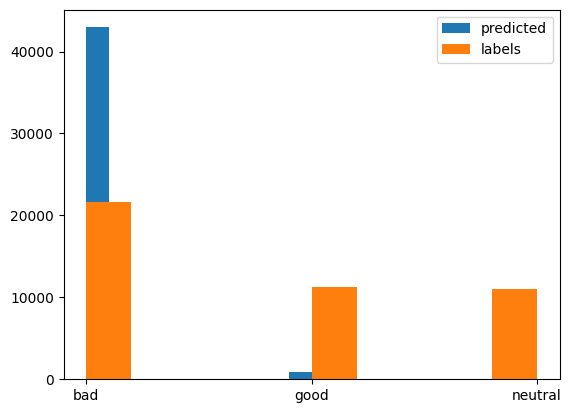

In [ ]:
import matplotlib.pyplot as plt
plt.hist(ps, label = 'predicted');
plt.hist(ls, label = 'labels');
plt.legend()

NAIVE BAYES

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['joined'])
X_test = vectorizer.transform(test_df['joined'])

y_train = train_df['labels']
y_test = test_df['labels']

naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

y_pred = naive_bayes.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7423561868715657


NEW DATA PREDICTION WITH NAIVE BAYES

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

X = df['joined']
y = df['labels']

vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

nb_model = MultinomialNB()
nb_model.fit(X_vectorized, y)

def preprocess_and_predict(tweet):
    preprocessed_tweet = preprocessor(tweet)
    tweet_vectorized = vectorizer.transform([preprocessed_tweet])
    prediction = nb_model.predict(tweet_vectorized)[0]
    return prediction

# New data
new_tweet = "i don't know if i like it or not"
prediction = preprocess_and_predict(new_tweet)
print("Prediction:", prediction)


Prediction: good


SVM

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X = df['joined']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(probability=False, kernel='linear'))])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", accuracy)

SVM Accuracy: 0.8475


In [ ]:
#save the trained svm
import joblib
joblib.dump(pipeline, '/content/drive/MyDrive/svm_model.pkl')

['/content/drive/MyDrive/svm_model.pkl']

In [ ]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

my_stemmer = PorterStemmer()
nltk.download('wordnet')
nltk.download('stopwords')
num_reviews = df['tweets'].size
nltk.download('punkt')

def preprocessor(raw_review):
    clean1 = re.sub(r'http\S+', ' ', raw_review)
    clean2 = re.sub(r'www\S+', ' ', clean1)
    clean3 = re.sub(r'@\w+', ' ', clean2)
    clean4 = re.sub(r'#\w+', ' ', clean3)
    letters_only = re.sub("[^a-zA-Z]", " ", clean4)
    words = word_tokenize(letters_only.lower())
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in meaningful_words]
    return " ".join(lemmatized_words)
    # return lemmatized_words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import joblib
# Load the saved SVM model
pipeline = joblib.load('/content/drive/MyDrive/svm_model.pkl')

# New tweet to predict
new_tweet = "chatgpt is a good invention but also harmful for software developers' career"

preprocessed_tweet = preprocessor(new_tweet)
prediction = pipeline.predict([preprocessed_tweet])
print("Predicted label:", prediction[0])

Predicted label: neutral


RANDOM FOREST

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X = df['joined']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()

X_train_transformed = vectorizer.fit_transform(X_train)

X_test_transformed = vectorizer.transform(X_test)

rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train_transformed, y_train)

y_pred = rf_classifier.predict(X_test_transformed)

accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)

Random Forest Accuracy: 0.8079299573633689


In [ ]:
#save rf model
joblib.dump(pipeline, '/content/drive/MyDrive/rf_model.pkl')

['/content/drive/MyDrive/rf_model.pkl']

In [ ]:
# Load the saved model
pipeline = joblib.load('/content/drive/MyDrive/rf_model.pkl')

# New tweet to predict
new_tweet = "chatgpt is awesome but I'm not sure if I should use it"

preprocessed_tweet = preprocessor(new_tweet)

prediction = pipeline.predict([preprocessed_tweet])

print("Predicted label:", prediction[0])

Predicted label: good


RNN

In [ ]:
df['new_label'] = None

In [ ]:
for i in df.index:
    if df.labels[i] == 'bad' :
        df.loc[i, 'new_label'] = 0
    elif df.labels[i] == 'neutral':
        df.loc[i, 'new_label'] = 1
    elif df.labels[i] == 'good':
        df.loc[i, 'new_label'] = 2

In [ ]:
df.head()

,Unnamed: 0,tweets,labels,joined,new_label
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral,chatgpt optimizing language model dialogue,1
1,1,"Try talking with ChatGPT, our new AI system wh...",good,try talking chatgpt new ai system optimized di...,2
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral,chatgpt optimizing language model dialogue n n...,1
3,3,"THRILLED to share that ChatGPT, our new model ...",good,thrilled share chatgpt new model optimized dia...,2
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad,minute ago released new chatgpt n nand use right,0


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X = df['joined']
y = df['new_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max([len(tokens) for tokens in X_train_tokens])
X_train_padded = pad_sequences(X_train_tokens, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_tokens, maxlen=max_sequence_length, padding='post')

X_train_padded = tf.convert_to_tensor(X_train_padded, dtype=tf.int32)
X_test_padded = tf.convert_to_tensor(X_test_padded, dtype=tf.int32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=10, batch_size=32)

y_pred_prob = model.predict(X_test_padded)
y_pred = np.round(y_pred_prob).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print("RNN Accuracy:", accuracy)

Epoch 1/10
5483/5483 [==============================] - 76s 13ms/step - loss: -55.6008 - accuracy: 0.5376 - val_loss: -123.1615 - val_accuracy: 0.5803
Epoch 2/10
5483/5483 [==============================] - 44s 8ms/step - loss: -171.6275 - accuracy: 0.5350 - val_loss: -250.1013 - val_accuracy: 0.5990
Epoch 3/10
5483/5483 [==============================] - 45s 8ms/step - loss: -316.7724 - accuracy: 0.5897 - val_loss: -375.1447 - val_accuracy: 0.5720
Epoch 4/10
5483/5483 [==============================] - 43s 8ms/step - loss: -475.8191 - accuracy: 0.6159 - val_loss: -541.7548 - val_accuracy: 0.6279
Epoch 5/10
5483/5483 [==============================] - 44s 8ms/step - loss: -637.2718 - accuracy: 0.6361 - val_loss: -716.8143 - val_accuracy: 0.6463
Epoch 6/10
5483/5483 [==============================] - 45s 8ms/step - loss: -819.2163 - accuracy: 0.6533 - val_loss: -847.2174 - val_accuracy: 0.6527
Epoch 7/10
5483/5483 [==============================] - 42s 8ms/step - loss: -997.9658 - accur

In [ ]:
#save rnn model
model.save('/content/drive/MyDrive/rnn_model.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the saved model
model = load_model('/content/drive/MyDrive/rnn_model.h5')

tokenizer = Tokenizer()
max_sequence_length = max([len(tokens) for tokens in X_train_tokens])

def preprocess_tweet(tweet):
    tokens = tokenizer.texts_to_sequences([tweet])
    padded_sequence = pad_sequences(tokens, maxlen=max_sequence_length)
    return padded_sequence

# New tweet to predict
new_tweet = "i don't know if i like it"

preprocessed_tweet = preprocess_tweet(new_tweet)

predictions = model.predict(preprocessed_tweet)
predicted_label = tf.argmax(predictions, axis=1).numpy()[0]

if predicted_label == 0:
  predicted_label = 'bad'
elif predicted_label == 1:
  predicted_label = 'neutral'
elif predicted_label == 2:
  predicted_label = 'good'

print("Predicted Label:", predicted_label)

1/1 [==============================] - 1s 545ms/step
Predicted Label: bad


CNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df['joined']
y = df['new_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)


max_sequence_length = max([len(tokens) for tokens in X_train_tokens])
X_train_padded = pad_sequences(X_train_tokens, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_tokens, maxlen=max_sequence_length, padding='post')

X_train_padded = tf.convert_to_tensor(X_train_padded, dtype=tf.int32)
X_test_padded = tf.convert_to_tensor(X_test_padded, dtype=tf.int32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=10, batch_size=32)

y_pred_prob = model.predict(X_test_padded)
y_pred = np.round(y_pred_prob).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print("CNN Accuracy:", accuracy)

Epoch 1/10
5483/5483 [==============================] - 70s 12ms/step - loss: -92619.0469 - accuracy: 0.5026 - val_loss: -324672.5000 - val_accuracy: 0.5224
Epoch 2/10
5483/5483 [==============================] - 36s 7ms/step - loss: -961455.7500 - accuracy: 0.5181 - val_loss: -1813087.2500 - val_accuracy: 0.5099
Epoch 3/10
5483/5483 [==============================] - 33s 6ms/step - loss: -3302530.7500 - accuracy: 0.5208 - val_loss: -5032567.0000 - val_accuracy: 0.5171
Epoch 4/10
5483/5483 [==============================] - 32s 6ms/step - loss: -7697423.5000 - accuracy: 0.5221 - val_loss: -10568711.0000 - val_accuracy: 0.5162
Epoch 5/10
5483/5483 [==============================] - 31s 6ms/step - loss: -14726738.0000 - accuracy: 0.5222 - val_loss: -18960358.0000 - val_accuracy: 0.5147
Epoch 6/10
5483/5483 [==============================] - 32s 6ms/step - loss: -24940060.0000 - accuracy: 0.5214 - val_loss: -30762702.0000 - val_accuracy: 0.5186
Epoch 7/10
5483/5483 [======================

In [ ]:
#save cnn model
model.save('/content/drive/MyDrive/cnn_model.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the saved model
model = load_model('/content/drive/MyDrive/cnn_model.h5')

tokenizer = Tokenizer()
max_sequence_length = max([len(tokens) for tokens in X_train_tokens])

def preprocess_tweet(tweet):
    tokens = tokenizer.texts_to_sequences([tweet])
    padded_sequence = pad_sequences(tokens, maxlen=max_sequence_length)
    return padded_sequence

# New tweet to predict
new_tweet = "i love it"

preprocessed_tweet = preprocess_tweet(new_tweet)

predictions = model.predict(preprocessed_tweet)
predicted_label = tf.argmax(predictions, axis=1).numpy()[0]

if predicted_label == 0:
  predicted_label = 'bad'
elif predicted_label == 1:
  predicted_label = 'neutral'
elif predicted_label == 2:
  predicted_label = 'good'

print("Predicted Label:", predicted_label)

1/1 [==============================] - 0s 126ms/step
Predicted Label: bad
